In [1]:
import pandas as pd
import numpy as np
import sys
import os
from datetime import datetime
sys.path.append("/Users/yuchenlin/Project/Tools/Asset-Pricing-Tools")
import basictool
import anomalytest


In [2]:
engine = anomalytest.BacktestEngine(stdate=datetime(1960,1,1),eddate=datetime(2024,12,30))

Initializing BacktestEngine...
Loading raw data files...
Loading factor models...
Processing raw CRSP data...
CRSP data processing complete.
BacktestEngine initialized successfully.


In [3]:
raw_path = '~/Raw_data/'

FILE_PATHS = {
    "compustat_annual": raw_path + "COMPUSTAT/funda.csv",  
    "crsp_monthly": raw_path + "CRSP/msf.csv",      
    "ccm_link_table": raw_path + "CRSP/ccmxpf_lnkhist.csv",
    "compustat_quarter" :  raw_path + "COMPUSTAT/fundq.csv"
}
FRED_PATH = raw_path + 'FRED/'

In [4]:
def clean_wrds_dates(series):
    """
    统一清洗 WRDS 导出的日期列。
    处理 'E', '99999999' -> 未来日期
    处理 'B', '00000000' -> 过去日期
    处理其他无法解析的字符 -> NaT
    """
    # 1. 替换特殊代码 (根据你的数据情况，可以添加更多映射)
    replacements = {
        'E': '2099-12-31',
        '99999999': '2099-12-31',
        'C': '2099-12-31', # 有时 C 也代表 Current
        'B': '1900-01-01',
        '00000000': '1900-01-01'
    }
    
    # 2. 执行替换
    # 注意：先转成字符串处理，防止原本已经是混合类型
    series = series.astype(str).replace(replacements)
    
    # 3. 转换为日期格式
    # errors='coerce' 会把剩下的无法识别的乱码变成 NaT
    return pd.to_datetime(series, errors='coerce')

In [5]:
def get_statutory_tax_rate(year):
    """
    返回美国联邦法定最高企业所得税率 (1963-2020)
    数据来源: IRS / Tax Foundation
    """
    if year <= 1963:
        return 0.52
    elif year == 1964:
        return 0.50
    elif 1965 <= year <= 1967:
        return 0.48
    elif 1968 <= year <= 1969:
        return 0.528  # 包含附加税
    elif year == 1970:
        return 0.492
    elif 1971 <= year <= 1978:
        return 0.48
    elif 1979 <= year <= 1986:
        return 0.46
    elif year == 1987:
        return 0.40   # 1986税改过渡
    elif 1988 <= year <= 1992:
        return 0.34
    elif 1993 <= year <= 2017:
        return 0.35
    elif year >= 2018:
        return 0.21
    else:
        return 0.35 # 默认值，防止报错

In [6]:
def compute_future_yearly(df: pd.DataFrame, var_list: list, diff_list: list, lag: int = 1) -> pd.DataFrame:

    if not all(col in df.columns for col in ['permno', 'year']):
        raise ValueError("输入DataFrame必须包含 'permno' 和 'year' 列。")

    # 创建左右两个表，与SAS的 `a` 和 `b` 完全对应
    df_left = df.copy()
    df_right = df[['permno', 'year'] + var_list].copy()

    # 准备右表的连接键，与 a.FYEAR = b.FYEAR + lag 对应
    df_right['fyear_join_key'] = df_right['year'] - lag
    
    # 重命名右表的列，以 '_lag' 结尾
    lag_col_names = {var: f"{var}_t{lag}" for var in var_list}
    df_right.rename(columns=lag_col_names, inplace=True)
    
    # 执行 LEFT JOIN，与SAS的逻辑完全一致
    merged_df = pd.merge(
        df_left,
        df_right.drop(columns='year'), # 丢弃原始fyear，只保留join_key
        left_on=['permno', 'year'],
        right_on=['permno', 'fyear_join_key'],
        how='left' # <-- 明确使用 LEFT JOIN
    )
    
    if not diff_list:
        for var in diff_list:
            merged_df["{}_diff{}".format(var,lag)] = merged_df["{}".format(var)] - merged_df['{}_lag{}'.format(var,lag)]

    return merged_df.drop(columns='fyear_join_key')

In [7]:
def compute_lag_yearly(df: pd.DataFrame, var_list: list, diff_list: list, lag: int = 1) -> pd.DataFrame:

    if not all(col in df.columns for col in ['gvkey', 'fyear']):
        raise ValueError("输入DataFrame必须包含 'gvkey' 和 'fyear' 列。")

    # 创建左右两个表，与SAS的 `a` 和 `b` 完全对应
    df_left = df.copy()
    df_right = df[['gvkey', 'fyear'] + var_list].copy()

    # 准备右表的连接键，与 a.FYEAR = b.FYEAR + lag 对应
    df_right['fyear_join_key'] = df_right['fyear'] + lag
    
    # 重命名右表的列，以 '_lag' 结尾
    lag_col_names = {var: f"{var}_lag{lag}" for var in var_list}
    df_right.rename(columns=lag_col_names, inplace=True)
    
    # 执行 LEFT JOIN，与SAS的逻辑完全一致
    merged_df = pd.merge(
        df_left,
        df_right.drop(columns='fyear'), # 丢弃原始fyear，只保留join_key
        left_on=['gvkey', 'fyear'],
        right_on=['gvkey', 'fyear_join_key'],
        how='left' # <-- 明确使用 LEFT JOIN
    )
    
    if not diff_list:
        for var in diff_list:
            merged_df["{}_diff{}".format(var,lag)] = merged_df["{}".format(var)] - merged_df['{}_lag{}'.format(var,lag)]

    return merged_df.drop(columns='fyear_join_key')

def _load_required_data(paths: dict):
    """
    内部辅助函数，用于从指定路径加载所有必需的数据文件。
    """
    print("Loading required data files...")
    cols = ['gvkey','indfmt','datafmt','consol','fic','datadate','sic','fyear','fyr','at','capx','ppegt','dlc','dltt','dp','sppe','seq','txditc','pstkrv', 'pstkl', 'pstk','sale']
    try:
        compustat_annual = pd.read_csv(paths["compustat_annual"], low_memory=False,usecols=cols,dtype={'gvkey':str})
        numetic_cols = ['fyear','fyr','at','capx','ppegt','dlc','dltt','dp','sppe','seq','txditc','pstkrv', 'pstkl', 'pstk','sale']
        for col in numetic_cols:
            if col in compustat_annual.columns:
            # errors='coerce' 是关键：它会把无法转成数字的字符（如 'A', 'C'）直接变成 NaN
                compustat_annual[col] = pd.to_numeric(compustat_annual[col], errors='coerce')
        date_cols = ['datadate', 'linkdt', 'linkenddt', 'ipodate', 'dldte']

        for col in date_cols:
            if col in compustat_annual.columns:
                compustat_annual[col] = clean_wrds_dates(compustat_annual[col])

        crsp_monthly = engine.crsp_m_processed.copy()

        ccm_link_table = pd.read_csv(paths["ccm_link_table"], low_memory=False,dtype={'gvkey':str})
        ccm_link_table.columns = [i.lower() for i in ccm_link_table.columns]
        for col in date_cols:
            if col in ccm_link_table.columns:
                ccm_link_table[col] = clean_wrds_dates(ccm_link_table[col])
    except FileNotFoundError as e:
        print(f"错误：文件未找到。请确保在 FILE_PATHS 字典中提供了正确的路径。")
        raise e
        
    print("All data files loaded successfully.")
    return compustat_annual, crsp_monthly, ccm_link_table


In [8]:
compa, crspm, ccm_lnk = _load_required_data(FILE_PATHS)

Loading required data files...
All data files loaded successfully.


In [9]:
def create_annual_anomalies(
    compustat_annual: pd.DataFrame,
    crsp_monthly: pd.DataFrame,
    ccm_link_table: pd.DataFrame
):
    """
    Args:
        compustat_annual (pd.DataFrame): Compustat年度财务数据 (funda)。
            必需列: gvkey, datadate, fyear, 
                     
        crsp_monthly (pd.DataFrame): 经过预处理的CRSP月度数据 (如BacktestEngine的产出)。
            必需列: permno, date, me, exchcd.
            
        ccm_link_table (pd.DataFrame): CRSP-Compustat合并链接表。
            必需列: gvkey, lpermno, linkdt, linkenddt, linktype, linkprim.
    """
    print("--- Starting Annual Investment Anomaly Creation ---")

    # --- 步骤 1: 处理Compustat年度数据 (应用“黄金过滤器”并计算变量) ---
    print("Step 1: Processing Compustat annual data...")
    comp = compustat_annual.copy()
    comp['datadate'] = pd.to_datetime(comp['datadate'])
    comp['year'] = comp['datadate'].dt.year
    # 1a. 应用Compustat“黄金过滤器”
    comp = comp[
        (comp['indfmt'] == 'INDL') & (comp['datafmt'] == 'STD') &
        (comp['consol'] == 'C') &
        (comp['fic'] == 'USA') & comp['gvkey'].notna() & comp['fyear'].notna()
    ].copy()

    # --- 步骤 2: 处理变量是否用0填充以及计算diff---    
    na_list = ['sppe','txditc','dlc','dltt']
    for na_var in na_list:
        comp[na_var] = comp[na_var].fillna(0)
    
    lag_list = ['ppegt','at']
    diff_list = []

    # Construct BE
    comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
    comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
    comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])

    comp['be'] = comp['seq'] + comp['txditc'] - comp['ps']
    comp['be']=np.where(comp['be']>0, comp['be'], np.nan)
    
    comp = compute_lag_yearly(comp,lag_list,diff_list,1)

    # Construct firm variables 
    comp['ce'] = comp['capx'] / comp['sale']
    comp['debt'] = comp['dlc'] + comp['dltt']
    comp['delta'] = comp['dp'] / comp['ppegt_lag1']
    comp['capital'] = comp['ppegt_lag1']
    comp['investment'] = comp['capx'] - comp['sppe']
    comp['investment_alter'] = comp['at'] / comp['at_lag1'] - 1
    comp['output'] = comp['sale']

    comp = compute_lag_yearly(comp,['ce'],[],1)
    comp = compute_lag_yearly(comp,['ce'],[],2)
    comp = compute_lag_yearly(comp,['ce'],[],3)
    
    comp['ci'] = comp['ce'] / (comp['ce_lag1'] + comp['ce_lag2'] + comp['ce_lag3']) * 3
    comp.loc[comp['sale']<=0, 'ce'] = np.nan # 避免除以0
    # --- 步骤 3: 构建变量 ---

    # --- 步骤 4: 准备并链接CRSP-Compustat (CCM) -z-
    print("Step 2: Preparing and linking via CCM table...")
    ccm = ccm_link_table[
        (ccm_link_table['linktype'].isin(['LU', 'LC'])) &
        (ccm_link_table['linkprim'].isin(['P', 'C']))
    ].copy()
    ccm.rename(columns={'lpermno': 'permno'}, inplace=True)
    ccm['linkdt'] = pd.to_datetime(ccm['linkdt'])
    ccm['linkenddt'] = pd.to_datetime(ccm['linkenddt']).fillna(datetime(2099,12,30))


    # 链接Compustat与CCM
    comp_linked = pd.merge(comp, ccm, on='gvkey',how='inner')

    # 筛选有效的链接期间
    comp_linked = comp_linked[
        (comp_linked['datadate'] >= comp_linked['linkdt']) &
        (comp_linked['datadate'] <= comp_linked['linkenddt'])
    ]


    # --- 步骤 3: 创建CRSP的6月和12月锚点数据集 ---

    print("Step 3: Creating CRSP June and December anchor subsets...")
    crsp = crsp_monthly.copy()
    crsp['date'] = pd.to_datetime(crsp['date'])
    
    crsp_june = crsp[crsp['date'].dt.month == 6].copy()

    dec_me = crsp[crsp['date'].dt.month == 12][['permno', 'date', 'me']].rename(columns={'me': 'dec_me'})

    # --- 步骤 4: 执行“6月末”合并，并进行双重重复数据清洗 ---
    print("Step 4: Performing end-of-June merge and de-duplication...")
    
    # 4a. 创建合并键
    crsp_june['year_merge'] = crsp_june['date'].dt.year
    dec_me['year_merge'] = dec_me['date'].dt.year + 1
    comp_linked['year_merge'] = comp_linked['fyear'] + 1

    # 4b. 将6月CRSP数据与财务数据合并
    merged = pd.merge(crsp_june, comp_linked, on=['permno', 'year_merge'])

    # 4c. 第一层清洗：解决"permno-date" 匹配多个 "gvkey" 的问题
    # 优先选择 linkprim = 'P' (Primary)
    merged['linkprim'] = pd.Categorical(merged['linkprim'], categories=['C', 'P'], ordered=True)
    merged.sort_values(by=['permno', 'date', 'linkprim'], ascending=[True, True, False], inplace=True)
    merged = merged.drop_duplicates(subset=['permno', 'date'], keep='first')
    
    # 4d. 第二层清洗：解决公司变更财年导致同一年有多个财报的问题
    merged['calendar_year'] = merged['datadate'].dt.year
    merged.sort_values(by=['permno', 'calendar_year', 'datadate'], ascending=True, inplace=True)
    merged = merged.drop_duplicates(subset=['permno', 'calendar_year'], keep='last')

    # 4e. 合并12月市值 (DEC_ME)
    final_merged = pd.merge(merged, dec_me[['permno', 'year_merge', 'dec_me']], on=['permno', 'year_merge'], how='left')

    # --- 步骤 5: 计算最终的年度因子 ---
    print("Step 5: Calculating final annual anomalies...")
    
    # 账面市值比 (Book-to-Market)
    final_merged['BM'] = final_merged['be'] / final_merged['dec_me']
    
    # 市值因子 (Market Equity, ME) - 使用6月份的市值
    final_merged['ME'] = final_merged['me']
    
    # --- 步骤 6: 清理并输出 ---
    print("Step 6: Finalizing output DataFrame...")
    
    output_cols = ['gvkey','date','year','permno','siccd','shrcd','exchcd','fyear','fyr','prc','ret',
                   'at','output','capital','investment','investment_alter','delta','debt','ME','dec_me','ci','BM','dp']
    annual_factors = final_merged[output_cols].copy()
    # annual_factors = final_merged.copy()

    annual_factors.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    print(f"--- Annual Anomaly Creation Complete. Generated {len(annual_factors)} factor observations. ---")
    
    return annual_factors, crsp_june

In [10]:
prepared_data, crspjune = create_annual_anomalies(compa,crspm,ccm_lnk)

# fyear = t-1期末
# date = t (June)
# t(July) -> t+1 (June): r_{t+1} --  formation_date: t(June)

prepared_data['tau_t'] = (prepared_data['year']).apply(get_statutory_tax_rate)
prepared_data['tau_t1'] = (prepared_data['year'] + 1).apply(get_statutory_tax_rate)


--- Starting Annual Investment Anomaly Creation ---
Step 1: Processing Compustat annual data...
Step 2: Preparing and linking via CCM table...
Step 3: Creating CRSP June and December anchor subsets...
Step 4: Performing end-of-June merge and de-duplication...
Step 5: Calculating final annual anomalies...
Step 6: Finalizing output DataFrame...
--- Annual Anomaly Creation Complete. Generated 250158 factor observations. ---


In [11]:
fundemental_df = prepared_data[['year','permno','siccd','fyr','capital','investment','output','debt','dec_me','at','dp','tau_t','tau_t1',]]
fundemental_df = compute_future_yearly(fundemental_df,['output','capital','investment','debt','at','dp'],[],1)
for var in ['capital','output','debt','at'] + [i + '_t1' for i in ['capital','output','debt','at']]:  
    fundemental_df.loc[fundemental_df[var]<=0, var] = np.nan 

In [12]:
anom_df = prepared_data[['date','permno','exchcd','ME','BM','ci']]
anom_df['year'] = anom_df['date'].dt.year
anom_df.loc[anom_df['BM']<=0, 'BM'] = np.nan 

/var/folders/sb/y5d9zrdx4f191rc45t2grjr80000gn/T/ipykernel_49083/3517305890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anom_df['year'] = anom_df['date'].dt.year


In [13]:
# roughly calculate r^B
baa = pd.read_csv(FRED_PATH + 'Baayield.csv',parse_dates=['observation_date'])
baa['year'] = baa['observation_date'].dt.to_period('Y-Jun').dt.year -1
baa['r^b'] = baa.groupby('year')['BAA'].transform('mean')
baa['r^b'] = baa['r^b']/100
baa = baa[['year','r^b']]
baa = baa.drop_duplicates(['year'])

/var/folders/sb/y5d9zrdx4f191rc45t2grjr80000gn/T/ipykernel_49083/4193323722.py:3: FutureWarning: 'Y-Jun' is deprecated and will be removed in a future version, please use 'Y-JUN' instead.
  baa['year'] = baa['observation_date'].dt.to_period('Y-Jun').dt.year -1


In [14]:
final_df = anom_df.merge(fundemental_df,on=['year','permno']).merge(baa,on=['year'],how='left')

In [15]:
BM_group = final_df[(final_df['fyr'] == 12)
                             &(~final_df['siccd'].between(4000,4999))
                             &(~final_df['siccd'].between(6000,6999))]  
BM_group = BM_group.drop('ci',axis=1)
BM_group = BM_group.dropna()
CI_group = final_df[(final_df['fyr'] == 12)
                             &(~final_df['siccd'].between(4000,4999))
                             &(~final_df['siccd'].between(6000,6999))]
CI_group = CI_group.drop('BM',axis=1)
CI_group = CI_group.dropna()

In [16]:
BM_group.to_csv('BM_group.csv')
CI_group.to_csv('CI_group.csv')

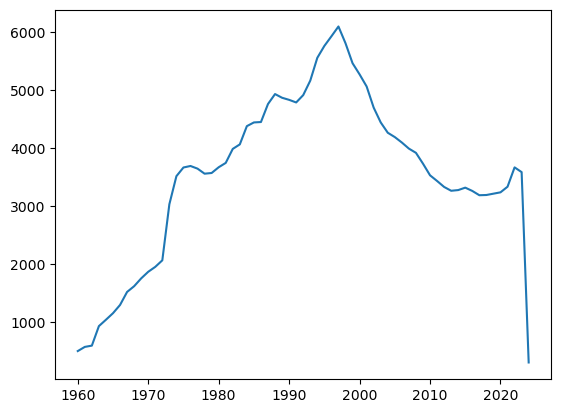

In [17]:
import matplotlib.pyplot as plt
plt.plot(final_df.groupby('year')['permno'].count())

In [18]:
print("========== 数据流失诊断报告 ==========")
prepared_data1 = final_df[(final_df['date']>=datetime(1963,1,1)) & (final_df['date']<=datetime(2005,12,31))]
print(f"0. 原始 prepared_data 样本量: {len(prepared_data1)}")

cols_to_check = ['at','capital','output','debt','at_t1', 'capital_t1', 'output_t1','investment','investment_t1']
for col in cols_to_check:
    num_missing = prepared_data1[col].isnull().sum()
    print(f"   变量 {col} 缺失数量: {num_missing} (占比: {num_missing/len(prepared_data1):.1%})")

# 1. 检查 fyr = 12 的影响
df_step1 = prepared_data1[prepared_data1['fyr'] == 12]
print(f"1. 筛选 fyr=12 后: {len(df_step1)} (流失率: {1 - len(df_step1)/len(prepared_data1):.1%})")

# 2. 检查行业剔除的影响
df_step2 = df_step1[
    (~df_step1['siccd'].between(4000,4999)) & 
    (~df_step1['siccd'].between(6000,6999))
]
print(f"2. 剔除金融/公用事业后: {len(df_step2)} (流失率: {1 - len(df_step2)/len(df_step1):.1%})")

# 3. 检查正变量筛选的影响 (at, capital, output > 0)
# 通常这些不会剔除太多，除非数据质量很差
df_step3 = df_step2[
    (df_step2['at'] > 0) & 
    (df_step2['capital'] > 0) & 
    (df_step2['output'] > 0) 
]
print(f"3. 剔除负资产/负产出后: {len(df_step3)} (流失率: {1 - len(df_step3)/len(df_step2):.1%})")

# 4. 检查 Leverage > 0 的影响 (嫌疑人 A)
df_step4 = df_step3[df_step3['debt'] > 0]
print(f"4. 剔除零杠杆(Zero Debt)后: {len(df_step4)} (流失率: {1 - len(df_step4)/len(df_step3):.1%})")

# 5. 检查 BM > 0 的影响
df_step5 = df_step4[df_step4['BM'] > 0]
print(f"5. 剔除负 BM 后: {len(df_step5)} (流失率: {1 - len(df_step5)/len(df_step4):.1%})")

# 6. 检查 dropna 的影响 (嫌疑人 B - 终极杀手)
# 我们先看看还没 dropna 之前有多少
print(f"--- 准备进入 dropna 环节，当前样本: {len(df_step5)} ---")

# 检查关键变量的缺失情况
cols_to_check = ['at_t1', 'investment','investment_t1','capital_t1', 'output_t1']
for col in cols_to_check:
    num_missing = df_step5[col].isnull().sum()
    print(f"   变量 {col} 缺失数量: {num_missing} (占比: {num_missing/len(df_step5):.1%})")

df_final = df_step5.dropna()
print(f"6. 最终 dropna 后 (BM_group): {len(df_final)}")

========== 数据流失诊断报告 ==========
0. 原始 prepared_data 样本量: 165524
   变量 at 缺失数量: 2888 (占比: 1.7%)
   变量 capital 缺失数量: 18355 (占比: 11.1%)
   变量 output 缺失数量: 4566 (占比: 2.8%)
   变量 debt 缺失数量: 19277 (占比: 11.6%)
   变量 at_t1 缺失数量: 16019 (占比: 9.7%)
   变量 capital_t1 缺失数量: 29910 (占比: 18.1%)
   变量 output_t1 缺失数量: 17477 (占比: 10.6%)
   变量 investment 缺失数量: 18457 (占比: 11.2%)
   变量 investment_t1 缺失数量: 29857 (占比: 18.0%)
1. 筛选 fyr=12 后: 97221 (流失率: 41.3%)
2. 剔除金融/公用事业后: 65784 (流失率: 32.3%)
3. 剔除负资产/负产出后: 64415 (流失率: 2.1%)
4. 剔除零杠杆(Zero Debt)后: 57590 (流失率: 10.6%)
5. 剔除负 BM 后: 53436 (流失率: 7.2%)
--- 准备进入 dropna 环节，当前样本: 53436 ---
   变量 at_t1 缺失数量: 4287 (占比: 8.0%)
   变量 investment 缺失数量: 653 (占比: 1.2%)
   变量 investment_t1 缺失数量: 4875 (占比: 9.1%)
   变量 capital_t1 缺失数量: 4324 (占比: 8.1%)
   变量 output_t1 缺失数量: 4384 (占比: 8.2%)
6. 最终 dropna 后 (BM_group): 40365
